In [26]:
import pandas as pd
from dowhy import CausalModel
import statsmodels.api as sm
import warnings

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBRegressor

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta.tmle import TMLELearner
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel, GradientBoostedPropensityModel
from causalml.dataset import *
from causalml.metrics import *
from causalml.inference.tree import CausalRandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
df = pd.read_csv("C:/Users/hanch/OneDrive/Desktop/research/NHEFS/NHEFS.csv")

covariates = [
    "qsmk",
    "wt82_71",
    "sex",
    "age",
    "race",
    "education",
    "smokeintensity",
    "smokeyrs",
    "active",
    "exercise",
    "wt71"
]

df = df[covariates]
df = df.dropna(subset=["qsmk", "wt82_71"])


In [4]:
data = {
    "data": df,
    "treatment": ["qsmk"],
    "outcome": ["wt82_71"],
    "graph": """
        graph[directed 1
            node[ id "wt82_71" label "wt82_71"]
            node[ id "qsmk" label "qsmk"]
            node[ id "age" label "age"]
            node[ id "sex" label "sex"]
            node[ id "race" label "race"]
            node[ id "education" label "education"]
            node[ id "smokeintensity" label "smokeintensity"]
            node[ id "smokeyrs" label "smokeyrs"]
            node[ id "exercise" label "exercise"]
            node[ id "active" label "active"]
            node[ id "wt71" label "wt71"]
            
            edge[ source "qsmk" target "wt82_71"]

            edge[ source "age" target "qsmk"]
            edge[ source "sex" target "qsmk"]
            edge[ source "race" target "qsmk"]
            edge[ source "education" target "qsmk"]
            edge[ source "smokeintensity" target "qsmk"]
            edge[ source "smokeyrs" target "qsmk"]
            edge[ source "exercise" target "qsmk"]
            edge[ source "active" target "qsmk"]
            edge[ source "wt71" target "qsmk"]
            
            edge[ source "age" target "wt82_71"]
            edge[ source "sex" target "wt82_71"]
            edge[ source "race" target "wt82_71"]
            edge[ source "education" target "wt82_71"]
            edge[ source "smokeintensity" target "wt82_71"]
            edge[ source "smokeyrs" target "wt82_71"]
            edge[ source "exercise" target "wt82_71"]
            edge[ source "active" target "wt82_71"]
            edge[ source "wt71" target "wt82_71"]
        ]
        """


}


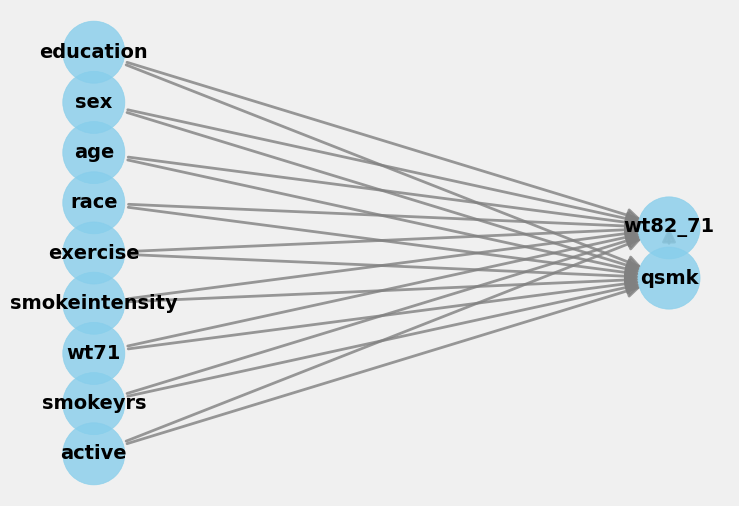

In [15]:
model = CausalModel(
    data = df,
    treatment = data["treatment"],
    outcome = data["outcome"],
    graph = data["graph"]
)
model.view_model()

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable = True)
print(identified_estimand.get_backdoor_variables())
print()
print(identified_estimand)

['active', 'smokeyrs', 'wt71', 'smokeintensity', 'exercise', 'race', 'age', 'sex', 'education']

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                           ↪
───────(E[wt_82_71|active,smokeyrs,wt71,smokeintensity,exercise,race,age,sex,e ↪
d[qsmk]                                                                        ↪

↪           
↪ ducation])
↪           
Estimand assumption 1, Unconfoundedness: If U→{qsmk} and U→wt82_71 then P(wt82_71|qsmk,active,smokeyrs,wt71,smokeintensity,exercise,race,age,sex,education,U) = P(wt82_71|qsmk,active,smokeyrs,wt71,smokeintensity,exercise,race,age,sex,education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
   d                                                         

In [12]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals())

2.7758052408052563
(1.3083640072908826, 3.4484562071201053)


In [8]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

3.050338420076117
(2.097509463975854, 4.113298236300853)


In [9]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

2.787346616289911
(1.5514313503192856, 3.763103435236272)


In [10]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

3.3488237857996017
[[2.48304875 4.21459882]]


In [11]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.generalized_linear_model",
           method_params={
            "glm_family": sm.families.Gaussian()
        }
    )
print(causal_estimate.value)
print(causal_estimate.get_confidence_intervals(confidence_level=0.95))

3.3488237857996
(2.315613037069821, 4.265996907749747)


In [ ]:
y, X, treatment = (df["wt82_71"], df.drop(columns=["qsmk", "wt82_71"]), df["qsmk"])

from causalml.propensity import LogisticRegressionPropensityModel

pm = LogisticRegressionPropensityModel(
    clip_bounds=(0.02, 0.98),
    calibrate=True
)

e = pm.fit_predict(X[:100], treatment[:100])
print(e[:30])


[0.02       0.11764706 0.02       0.11764706 0.02       0.02
 0.02       0.11764706 0.11764706 0.02       0.98       0.02
 0.02       0.02       0.98       0.02       0.02       0.98
 0.02       0.02       0.02       0.02       0.98       0.02
 0.02       0.02       0.98       0.11764706 0.02       0.02      ]


In [ ]:
learner_x = BaseXRegressor(learner=XGBRegressor())
ate = learner_x.estimate_ate(X=X, treatment=treatment, y=y, )